In [1]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
top_path = '..'
if top_path not in sys.path:
    sys.path.append(top_path)

coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
if coffea_path not in sys.path:
    sys.path.insert(0,coffea_path)
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util
from pltStyle import pltStyle
import mplhep as hep
pltStyle('hep')
# %matplotlib notebook 
# %matplotlib notebook 

In [3]:
from helpers import hist_add, hist_mult, hist_div, dictionary_pattern, sum_subhist, xsecstr2float
from helpers import sum_neg_pos_eta, read_data
from helpers import rebin_hist, add_flavors

In [4]:
# add_tag = '_QCD-JME-leading3jets' #-etaAut18'
# add_tag = '_QCD-JME' #-etaAut18'
# add_tag = '_QCD-MG-Py8'
# add_tag = '_QCD-MG-Her'
add_tag = '_DY-MG-Her'
# add_tag = '_Herwig-TTBAR'
add_tag = '_Pythia-TTBAR'

def get_output(add_tag):
    ''' Load response histogram data with the tag `add_tag`
    '''
    tag_full = '_L5'+add_tag
    outname = '../out/CoffeaJERCOutputs'+tag_full+'.coffea'
    output = util.load(outname)
    return output

In [5]:
def get_file_dict(add_tag):
    ''' Load a text file with cross sections and file names as a dictionary `file_dict`.
    '''
    if "_QCD-MG" in add_tag:
        if add_tag=='_DY-MG-Her':
            dataset_list_file = '../fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt'
        else:
            dataset_list_file = '../fileNames/QCD_MG_Py8_20UL18/xsecs_QCD_MG_py8.txt'
        with open(dataset_list_file) as f:
            lines = f.readlines()
        lines_split = [line.split() for line in lines]
        file_dict = {lineii[1]: xsecstr2float(lineii[2]) for lineii in lines_split }
    else:
        file_dict = 1
    return file_dict

In [6]:
# output_orig = output
def sum_output(output, add_tag, file_dict):
    ''' If the file with histograms `output` contains a dictionary over many datasets (e.g. different pt ranges),
    sum them up proportionally to the cross sections in `file_dict` 
    Output: summed up hisograms `output`
    '''
    if "_QCD-MG" in add_tag:
        response_sums = {key:sum(dictionary_pattern(output[key], "ptresponse_").values()).sum().value for key in output.keys()}
        scale_factors = hist_div(file_dict, response_sums)
        all_histo_keys = output[next(iter(output.keys()))].keys()
        result = {histo_key:sum_subhist(output, histo_key, scale_factors) for histo_key in all_histo_keys }
        output = result
    elif len(output.keys())==1:
        output = output[list(output.keys())[0]]
    return output

In [7]:
### Using one example histogram in `output`, get the appropriate pt and eta bins
output = get_output(add_tag)
file_dict = get_file_dict(add_tag)
output = sum_output(output, add_tag, file_dict)
    
for key in output.keys():
    if 'response' in key:
        response_key = key
        break
        
fine_etabins=False
one_bin=False
if fine_etabins==True:
    ptbins = np.array([15, 40, 150, 400, 4000, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = output[response_key].axes["jeteta"].edges #output['ptresponse'].axis('jeteta').edges()
elif one_bin==True:
    ptbins = np.array([15, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    etabins = np.array([etabins[0], 0, etabins[-1]])
#     etabins = np.array([etabins[3], 0, etabins[-4]])
else:
    ptbins = output[response_key].axes["pt_gen"].edges 
#     ptbins = ptbins[2:] #because there is a pt cut on pt gen and no point of fitting and plotting below that
    ptbins_c = output[response_key].axes['pt_gen'].centers
#     etabins = np.array([-5.191, -3.489, -3.139, -2.853,   -2.5, -2.322,  -1.93, -1.653, -1.305, -0.783,      0,  0.783,  1.305,  1.653,   1.93,  2.322,    2.5,  2.853,  3.139,  3.489, 5.191])
    etabins = np.array([-5.191, -2.964, -2.5, -1.305, 0, 1.305, 2.5, 2.964, 5.191])
    
etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2

### Sum together all the different flavors

In [10]:
def combine_flavors(output, sumeta=True, include_unmatched=True):
    flavors = (['g', 'c', 'b', 'q', 'unmatched', 'all_unmatched'] if include_unmatched==True
               else ['g', 'c', 'b', 'q', 'all'])
    hists = {}
    for flav in flavors:
        combined = add_flavors(output, flavor=flav, combine_antiflavour=True )[0]
        if sumeta:
            combined = combined[:,sum,sum]
        else:
            combined = combined[:,sum,:]
        flav2 = flav if not flav=='all_unmatched' else 'all'
        hists[flav2] = combined
    return hists
 

In [14]:
from scipy.optimize import curve_fit

def poly4(x, *p):
    c0, c1, c2, c3, c4 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3+c4*xs**4
    return res

def fit_Efractions(qfracs):
    fit_res = []
    for etaidx in range(len(qfracs[0])):
        qfrac = qfracs[:,etaidx]
        valid_fit_val = ~(np.isnan(qfrac) | np.isinf(qfrac) | (qfrac==0))
        ptbins_c_plot = ptbins_c[valid_fit_val]

        if not 'unmatched' in flav:
            p, arr2 = curve_fit(poly4, ptbins_c_plot, qfrac[valid_fit_val], p0=[1,1,1,1, 1]) #, sigma=np.sqrt(qfrac_var2[flav])[valid_fit_val])
        else:
            p, arr2 = curve_fit(poly4, ptbins_c_plot, qfrac[valid_fit_val], p0=[1,1,1,1, 1])

        if len(fit_res)==0:
            fit_res = p
        else:
            fit_res = np.vstack([fit_res, p])

    return fit_res

# fit_Efractions(qfracs2['q'])

In [15]:
from scipy.interpolate import CubicSpline
def get_spline(yval):
    valid_fit_val = ~(np.isnan(yval) | np.isinf(yval) | (yval==0))
    ptbins_c_plot = ptbins_c[valid_fit_val]
    yval = yval[valid_fit_val]

    spline_func = CubicSpline(np.log10(ptbins_c_plot), yval, bc_type='natural', extrapolate=False )
    return spline_func

In [157]:
import os
def plot_Efractions(sampledict, etaidx, saveplot=False):
    samples = list(sampledict.keys())

    ### Check that Herwig is the first sample and Pythia the second
    if not ('Her' in samples[0] and 'Py' in samples[1]):
        raise ValueError('key in the dictionary happened to get reversed')
    
    
    qfracs0, qfrac_var0, spline0, spline2D0 = sampledict[samples[0]]
    qfracs1, qfrac_var1, spline1, spline2D1 = sampledict[samples[1]]
    
    plot_range = range(0, np.searchsorted(ptbins_c,1250)) if 'DY' in "".join(samples) else range(0, np.searchsorted(ptbins_c,2750))
    ptbins_c_plot = ptbins_c[plot_range]
    
    fig, ax = plt.subplots()
    xplot = np.geomspace(ptbins_c_plot.min() - (1), ptbins_c_plot.max(),1000)
    xplot2 = np.geomspace(ptbins_c_plot.min(), ptbins_c_plot.max(),1000)
    points_ls = []
    for flav in qfracs0.keys():
        lab = flav if not flav=='q' else 'uds'
        mc = next(ax._get_lines.prop_cycler)

        points = ax.errorbar(ptbins_c_plot, qfracs0[flav][plot_range, etaidx],
                             yerr=np.sqrt(qfrac_var0[flav][plot_range, etaidx]),
                             linestyle='none', label=lab,  **mc, capsize=1.6, capthick=0.7, linewidth=1.0)
        points2 = ax.errorbar(ptbins_c_plot, qfracs1[flav][plot_range, etaidx],
                              yerr=np.sqrt(qfrac_var1[flav][plot_range, etaidx]),
                              linestyle='none', mfc='none', markeredgewidth=1.2, **mc, capsize=1.6, capthick=0.7, linewidth=1.0)

        valid_fit_val = ~(np.isnan(qfracs1[flav]) | np.isinf(qfracs1[flav]) | (qfracs1[flav]==0))
        
#         ax.plot(xplot, spline0[flav](np.log10(xplot)), '--', markersize=0, **mc, linewidth=1.0)
#         sp1 = ax.plot(xplot, spline1[flav](np.log10(xplot)), '--', markersize=0, **mc, linewidth=1.0)
        ax.plot(xplot2, spline2D0[flav]((np.log10(xplot2), [etabins_c[etaidx]]*len(xplot2))),
                      '-.', markersize=0, **mc, linewidth=1.0)
        ax.plot(xplot2, spline2D1[flav]((np.log10(xplot2), [etabins_c[etaidx]]*len(xplot2))),
              '-.', markersize=0, **mc, linewidth=1.0)
# interp((np.log(np.arange(20,60,2)),[1]*20))
        if 'g' == flav:
            points_ls.append(points[0])
            points_ls.append(points2[0])
        
    
    ax.set_xscale('log')
    ax.set_xlabel('$p_{T,Gen}$ (GeV)')
    ax.set_ylabel("Flavor fraction")
# fig.suptitle("Blaaah $x^2_5$")

    xlims = ax.get_xlim()

    ax.set_xticks([])
    ax.set_xticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    # ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    legend1 = ax.legend(points_ls, [samples[0][1:], samples[1][1:]], loc="upper left", bbox_to_anchor=(0.48, 1))
    leg2 = ax.legend(ncol=1, loc='upper right', bbox_to_anchor=(0.52, 1))
    ax.add_artist(legend1)
    # ax.add_artist(leg2)

    ylims = ax.get_ylim()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims[0], ylims[1]*1.25)

    # ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
#     hep.cms.label("Something", data=False, year=2018, fontsize=15.6/1.25)
#     hep.cms.label(data=False, fontsize=15.6/1.25, loc=3)
    hep.label.exp_text(text=f'$\eta$ = {etabins_mod[etaidx]}', loc=0)

    if saveplot:
        if not os.path.exists("../fig/fractions"):
            os.mkdir("../fig/fractions")

        fig_name = '../fig/fractions/fraction'+"".join(samples)
        print("Saving plot with the name = ", fig_name)
        plt.savefig(fig_name+'.pdf');
        plt.savefig(fig_name+'.png');

1;

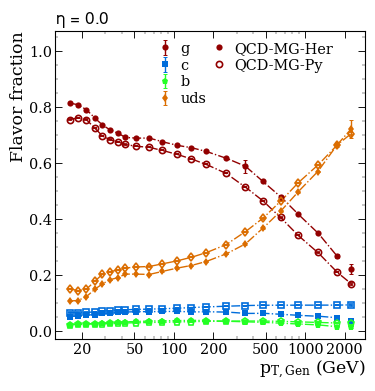

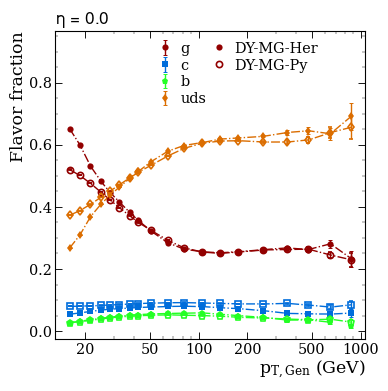

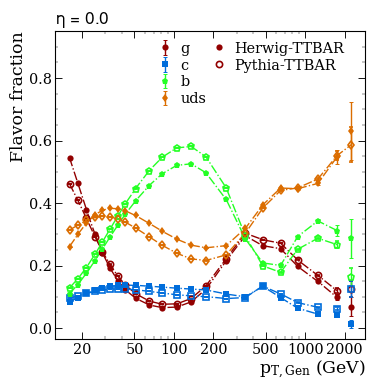

In [158]:
eta_idx = np.searchsorted(etabins_mod,0)
flavors = ['g', 'c', 'b', 'q'] #, 'unmatched']
samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

qfrac_dict = {}
qfrac_var_dict = {}
qfrac_spline_dict = {}
include_unmatched = False
flavors = ['g', 'c', 'b', 'q', 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'q']
saveplot = include_unmatched

for ii in range(len(samples)):
    sampHer = Her_samples[ii]
    sampPy = Py_samples[ii]
    samp = samples[ii]
    sample_plot = {}
    
    for sample in [sampHer, sampPy]:
        output = get_output(sample)
        file_dict = get_file_dict(sample)
        output = sum_output(output, sample, file_dict)
        hists = combine_flavors(output, sumeta=False)
            
        hists_rebinned = {flav: rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', etabins_mod) for flav in hists.keys() }
        if include_unmatched==False: #recalculate the all
            hists_rebinned['all'] = sum([hists_rebinned[flav] for flav in flavors])

        hists_vals = {}
        for flav in hists_rebinned.keys():
            vals = hists_rebinned[flav].values()
            vals[vals==0] = np.nan
            hists_vals[flav] = vals
        qfracs = {flav: hists_vals[flav]/hists_vals['all'] for flav in flavors}
#         qfracs_var = {flav: hists_rebinned[flav].variances()/hists_rebinned['all'].variances() for flav in flavors}
        qfrac_var = {'all': hists_rebinned['all'].variances()/hists_vals['all']**2}
        for flav in flavors:
            qfrac_var[flav] = qfracs[flav]**2*(hists_rebinned[flav].variances()/hists_vals[flav]**2 + qfrac_var['all']**2)
        
        Efrac_splines = {key: get_spline(qfracs[key][:,eta_idx]) for key in qfracs.keys() }
        Efrac_2Dsplines = {key: RegularGridInterpolator((np.log10(ptbins_c), etabins_c), qfracs[key], fill_value=None) 
                          for key in qfracs.keys()}
        
#         yval = qfracs['g'][:,0]


#         Efrac_fit_dict[sample] = Efrac_fits
        qfrac_dict[sample] = qfracs
        qfrac_var_dict[sample] = qfrac_var
        qfrac_spline_dict[sample] = Efrac_2Dsplines
        sample_plot[sample] = [qfracs, qfrac_var, Efrac_splines, Efrac_2Dsplines]

    plot_Efractions(sample_plot, eta_idx, saveplot=saveplot)
#         correction_dict[sample] = {flav: read_corrections(sample, flav) for flav in flavors}


### Deriving the uncertainties

In [71]:
pt200bin = np.searchsorted(ptbins,200)
# qfrac_dict = {}
# Efrac_fit_dict = {}
# correction_dict = {}

In [72]:
def read_data2(name, sample, flav):
    data = read_data(name, flav, "_L5"+sample+"_fineeta",'../')
    data[data==0] = np.nan
    return data

In [73]:
def read_corrections(sample, flav):
    data = read_data("Median", flav, "_L5"+sample+"_fineeta",'../')
    data[data==0] = np.nan
    return 1/data

In [76]:
# # a = np.array([])
# flavors = ['g', 'c', 'b', 'q']
# all_sum=rebin_hist(sum_neg_pos_eta(hists[flavors[0]]), 'jeteta', etabins_mod).values()
# for flav in flavors[1:]:
#     all_sum+=rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', etabins_mod).values()
    
# qfracs = {'all': all_sum}

In [74]:
# all_sum[0]

#### Obtain the fitted corrections

In [88]:
# flavors = ['g', 'c', 'b', 'q', 'unmatched']
from coffea.lookup_tools import extractor
corr_loc_Sum20_Py = ["* * ../Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py.txt"]
corr_loc_Sum20_Her = ["* * ../Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her.txt"]

ext = extractor()
ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
ext.finalize()
evaluator = ext.make_evaluator()

### Resum all the flavors for each sample

In [176]:
def get_ratio(a, b, divide=True):
    '''To obtain the JEC uncertainty instead of dividing Herwig by Python, the samples are subtracted'''
    if divide:
        return(a/b)
    else:
        return(a-b)
divideHerPy = True

In [169]:
inverse = False
xvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
etaidx = 0
etavals = np.ones(len(xvals))*etabins_mod[etaidx]
etavals2 = np.ones(len(xvals))*etabins_c[etaidx]
xvals_idx = np.searchsorted(ptbins,xvals)-1
xvals_idx[xvals_idx==-1]=0
etavals_idx = np.searchsorted(etabins_mod,etavals)
# flavors = ['g', 'c', 'b', 'q'] #, 'unmatched']
samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

HerPy_differences = {}
for ii in range(len(samples)):  
    sampHer = Her_samples[ii]
    sampPy = Py_samples[ii]
    samp = samples[ii]
    Efracspline_Her = qfrac_spline_dict[sampHer] #[flavors[0]]
    Efracspline_Py  = qfrac_spline_dict[sampPy]
    
    fract_Her = qfrac_dict[sampHer][flavors[0]][tuple([xvals_idx, etavals_idx])]
    fract_Py = qfrac_dict[sampPy][flavors[0]][tuple([xvals_idx, etavals_idx])]

    response_Her = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_{flavors[0]}J'](etavals, xvals)
    response_Py = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_{flavors[0]}J'](etavals, xvals)
    
    if inverse==False:
        response_Her = 1/response_Her
        response_Py = 1/response_Py
        
    Her = response_Her*fract_Her 
    Py = response_Py*fract_Py
    Her_spline = (response_Her*Efracspline_Her[flavors[0]]((np.log10(xvals), etavals2)))
    Py_spline = (response_Py*Efracspline_Py[flavors[0]]((np.log10(xvals), etavals2)))
    for flav in flavors[1:4]:
        fract_Her = qfrac_dict[sampHer][flav][tuple([xvals_idx, etavals_idx])]
        fract_Py = qfrac_dict[sampPy][flav][tuple([xvals_idx, etavals_idx])]
        response_Her = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_{flav}J'](etavals, xvals)
        response_Py = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_{flav}J'](etavals, xvals)
        if inverse==False:
            response_Her = 1/response_Her
            response_Py = 1/response_Py
        HerNew = response_Her*fract_Her 
        PyNew = response_Py*fract_Py
        Her_splineNew = (response_Her*Efracspline_Her[flav]((np.log10(xvals), etavals2)))
        Py_splineNew = (response_Py*Efracspline_Py[flav]((np.log10(xvals), etavals2)))
        
        Her += HerNew
        Py += PyNew
        Her_spline += Her_splineNew
        Py_spline += Py_splineNew
    
    HerPy = get_ratio(Her, Py, divideHerPy)
    HerPy_spline = get_ratio(Her_spline, Py_spline, divideHerPy)
    
    if inverse==True:
        a = read_corrections(sampHer, 'all')
        b = read_corrections(sampPy, 'all')
        delta_a = read_data2('MedianStd', sampHer, 'all')
        delta_b = read_data2('MedianStd', sampPy, 'all')
        corr_all = get_ratio(a, b, divideHerPy)[:,etaidx]
        if divideHerPy:
            corrstd_all = np.sqrt((delta_a*b)**2+(b/corr_all*delta_b*b**2)**2)[:,etaidx]
        else:
            corrstd_all = np.sqrt((delta_a*a**2)**2+(delta_b*b**2)**2)[:,etaidx]
    else:
        a = read_data2('Median', sampHer, 'all')
        b = read_data2('Median', sampPy, 'all')
        delta_a = read_data2('MedianStd', sampHer, 'all')
        delta_b = read_data2('MedianStd', sampPy, 'all')
        corr_all = get_ratio(a, b, divideHerPy)[:,etaidx]
        if divideHerPy:
            corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[:,etaidx]
        else:
            corrstd_all = np.sqrt(delta_a**2+delta_b**2)[:,etaidx]
    
    HerPy_differences[samp] = [HerPy, HerPy_spline, corr_all, corrstd_all]

NameError: name 'Summed_mixes' is not defined

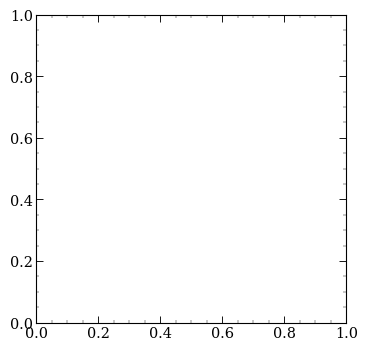

In [170]:
# all_corr = read_corrections('_QCD-MG-Her', 'all') - read_corrections('_QCD-MG-Her', 'all')
fig, ax = plt.subplots()
ax.plot(xvals, Summed_mixes['DY'][0], label='sum of each flavor', markersize=0)
# ax.plot(xvals, res2, label='sum of each flavor, fit', markersize=0)
ax.plot(xvals, Summed_mixes['DY'][1], label='sum of each flavor, fit 2', markersize=0, linewidth=2.5)
# ax.plot(xvals, Summed_mixes['DY'][2], label='sum of each flavor, fit 2', markersize=0)
for flav in flavors[:4]:
    mc = next(ax._get_lines.prop_cycler)
    ax.plot(xvals, All_flavorfits['DY'][flav], label=flav, markersize=0, **mc)
    ax.plot(xvals, All_flavor['DY'][flav], markersize=1, **mc)



# ax.plot(xvals, poly4(xvals, *Efracfit_Her[flavors[0]][0]), markersize=0)
# ax.plot(xvals, fract_Her, markersize=0)
# ax.plot(xvals, poly4(xvals, *Efracfit_Py[flavors[3]][0]), markersize=0)
# ax.plot(xvals, fract_Py, markersize=0)

# ax.plot(xvals, res_all, label='fit to all', markersize=0)
ax.errorbar(ptbins_c, Summed_mixes['DY'][5], yerr=Summed_mixes['DY'][7], label='all', linestyle='none')
# ax.plot(xvals, evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_{flavors[0]}J'](etavals, xvals) - evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_{flavors[0]}J'](etavals, xvals), markersize=0 )
# ax.plot(ptbins_c,np.abs(Rttbar) - np.abs(Rref))[:,0])
# ax.plot(ptbins_c,(np.abs(Rdijet) - np.abs(Rref))[:,0])
# inverse = False
ax.legend()
ax.set_xlim(15,1000)
# ax.set_ylim(0.987-0.0005,1.025+0.0005)
ax.set_ylim(0.007-0.0005,1.4+0.0005)
ax.set_xscale('log')

xlabel = r'$p_{T}$ (GeV)'
ax.set_xlabel(xlabel);
ylab_pre = 'Her7/Py8' 
ylabel = r' (correction)' if inverse else r' (median response)'
ax.set_ylabel(ylab_pre+ylabel);
ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
1;

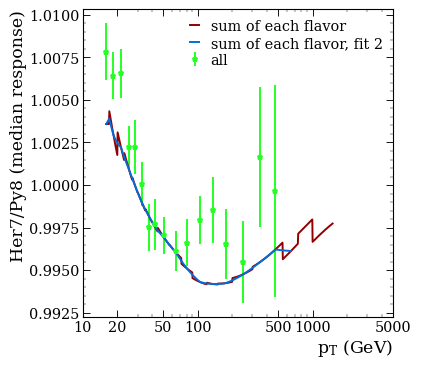

In [171]:
# all_corr = read_corrections('_QCD-MG-Her', 'all') - read_corrections('_QCD-MG-Her', 'all')
fig, ax = plt.subplots()
ax.plot(xvals, HerPy_differences['DY'][0], label='sum of each flavor', markersize=0)
# ax.plot(xvals, res2, label='sum of each flavor, fit', markersize=0)
ax.plot(xvals, HerPy_differences['DY'][1], label='sum of each flavor, fit 2', markersize=0)


# ax.plot(xvals, poly4(xvals, *Efracfit_Her[flavors[0]][0]), markersize=0)
# ax.plot(xvals, fract_Her, markersize=0)
# ax.plot(xvals, poly4(xvals, *Efracfit_Py[flavors[3]][0]), markersize=0)
# ax.plot(xvals, fract_Py, markersize=0)

# ax.plot(xvals, res_all, label='fit to all', markersize=0)
ax.errorbar(ptbins_c, HerPy_differences['DY'][2], yerr=HerPy_differences['DY'][3], label='all', linestyle='none')
# ax.plot(xvals, evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_{flavors[0]}J'](etavals, xvals) - evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_{flavors[0]}J'](etavals, xvals), markersize=0 )
# ax.plot(ptbins_c,np.abs(Rttbar) - np.abs(Rref))[:,0])
# ax.plot(ptbins_c,(np.abs(Rdijet) - np.abs(Rref))[:,0])
# inverse = False
ax.legend()
ax.set_xlim(15,1000)
# ax.set_ylim(-0.02,0.02)
ax.set_xscale('log')

xlabel = r'$p_{T}$ (GeV)'
ax.set_xlabel(xlabel);
ylab_pre = 'Her7/Py8' 
ylabel = r' (correction)' if inverse else r' (median response)'
ax.set_ylabel(ylab_pre+ylabel);
ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
1;

In [174]:
divideHerPy = True
flav = flavors[0]
pHer = (1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_{flav}J'](etavals, xvals)
         *qfrac_spline_dict['_DY-MG-Her'][flav]((np.log10(200),etabins_c[0])))
pPy = (1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_{flav}J'](etavals, xvals)
         *qfrac_spline_dict['_DY-MG-Py'][flav]((np.log10(200),etabins_c[0])))
for flav in flavors[1:]:
    pHer += (1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_{flav}J'](etavals, xvals)
           *qfrac_spline_dict['_DY-MG-Her'][flav]((np.log10(200),etabins_c[0])))
    pPy  += (1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_{flav}J'](etavals, xvals)
           *qfrac_spline_dict['_DY-MG-Py'][flav]((np.log10(200),etabins_c[0])))
g20q80 = get_ratio(pHer, pPy, divideHerPy)
    
# pHer = (
#  1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_gJ'](0, 200)*0.2
#  + 1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_qJ'](0, 200)*0.8
# )
# pPy = (
#     1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_gJ'](0, 200)*0.2
#   + 1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_qJ'](0, 200)*0.8
# )
# g20q80_fixed =  get_ratio(pHer, pPy, divideHerPy)


pHer = 0
pPy = 0
for flav in flavors:
    pHer += (1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_{flav}J'](0, 200)
             *qfrac_spline_dict['_DY-MG-Her'][flav]((np.log10(200),etabins_c[0])))
    pPy +=  (1/evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_{flav}J'](0, 200)
             *qfrac_spline_dict['_DY-MG-Py'][flav]((np.log10(200),etabins_c[0])))
g20q80_fixed = get_ratio(pHer, pPy, divideHerPy)

q100 = get_ratio(
    evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_qJ'](etavals, xvals),
    evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_qJ'](etavals, xvals),
    divideHerPy
     )

g100 = get_ratio(
    evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_gJ'](etavals, xvals),
    evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_gJ'](etavals, xvals),
    divideHerPy
    )

b100 = get_ratio(
    evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_bJ'](etavals, xvals),
    evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_bJ'](etavals, xvals),
    divideHerPy
     )

Saving plot with the name =  fig/Herwig_Pythia_all_samples_20g_80q.pdf / .png


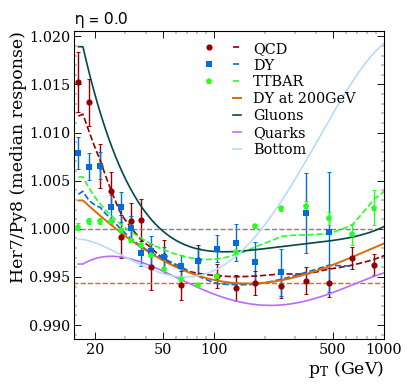

In [175]:
# all_corr = read_corrections('_QCD-MG-Her', 'all') - read_corrections('_QCD-MG-Her', 'all')
fig, ax = plt.subplots()

lines = []
for samp in ['QCD', 'DY', 'TTBAR']:    
    mc = next(ax._get_lines.prop_cycler)
#     ax.plot(xvals, HerPy_differences[samp][0], markersize=0, label=samp, **mc)
    ax.plot(xvals, HerPy_differences[samp][1], '--', label=samp, markersize=0, **mc, linewidth=1.2)
    line = ax.errorbar(ptbins_c, HerPy_differences[samp][2], yerr=HerPy_differences[samp][3],
                       linestyle='none', **mc, capsize=1.6, capthick=0.7, linewidth=1.0)
    lines.append(line[0])

# mc = next(ax._get_lines.prop_cycler)
# ax.plot(xvals, res_DY, markersize=0, label='DY', **mc)
# line2 = ax.errorbar(ptbins_c, response_all_DY, yerr=responsestd_all_DY, linestyle='none', **mc)

# mc = next(ax._get_lines.prop_cycler)
# ax.plot(xvals, res_TTBAR, markersize=0, label='TTBAR', **mc)
# line3 = ax.errorbar(ptbins_c, response_all_TTBAR, yerr=responsestd_all_TTBAR, linestyle='none', **mc)

pointsg20 = ax.plot(xvals, g20q80, label='DY at 200GeV', markersize=0)
ax.plot(xvals, g100, label='Gluons', markersize=0, linewidth=1.2)
ax.plot(xvals, q100, label='Quarks', markersize=0, linewidth=1.2)
ax.plot(xvals, b100, label='Bottom', markersize=0, linewidth=1.2)


ax.hlines(1,1, 10000, linestyles='--',color="gray",
    linewidth=1,)

ax.hlines(g20q80_fixed, 1, 10000, linestyles='--',color=pointsg20[0].get_markerfacecolor(),
    linewidth=1,)
# ax.plot(xvals, res2, label='sum of each flavor, fit', markersize=0)
# ax.plot(xvals, res3, label='sum of each flavor, fit 2', markersize=0)


# ax.plot(xvals, evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her_{flavors[0]}J'](etavals, xvals) - evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Py_{flavors[0]}J'](etavals, xvals), markersize=0 )
# ax.plot(ptbins_c,np.abs(Rttbar) - np.abs(Rref))[:,0])
# ax.plot(ptbins_c,(np.abs(Rdijet) - np.abs(Rref))[:,0])

# ax.legend(ncol=2)
legend1 = ax.legend(lines, ["", "", ""], loc="upper right", bbox_to_anchor=(0.52, 1)) #, title='correction', title_fontsize=10)
leg2 = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(0.48, 1))#, title='assembled\nfrom QCD', title_fontsize=10)
ax.add_artist(legend1)
xlabel = r'$p_{T}$ (GeV)'
ax.set_xlabel(xlabel);
ylab_pre = 'Her7/Py8' 
ylabel = r' (correction)' if inverse else r' (median response)'
ax.set_ylabel(ylab_pre+ylabel);
ax.set_xscale('log')
ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylim(0.9885,1.0205)
ax.set_xlim(15,1000)
hep.label.exp_text(text=f'$\eta$ = {etabins_mod[etaidx]}', loc=0)
fig_name = 'fig/Herwig_Pythia_all_samples_20g_80q'
print("Saving plot with the name = ", fig_name+".pdf / .png")
plt.savefig(fig_name+'.pdf');
plt.savefig(fig_name+'.png');

1;

In [639]:
def getRf(samp1, samp2, use_each_mix=False):
    '''Rf defined in Eq.(26) in https://arxiv.org/pdf/1607.03663.pdf'''
    if use_each_mix==False:        
        Rf = hist_mult(
            hist_add(
                correction_dict[samp1],
                hist_mult(correction_dict[samp2],-1)
            ),
        qfrac_dict[samp1])
    else:
        Rf = hist_add(
            hist_mult(
                correction_dict[samp1],
                qfrac_dict[samp1]
            ),
            hist_mult(
                hist_mult(
                    correction_dict[samp2],
                    qfrac_dict[samp2]
                ),
                -1
            )
        )
    return Rf

In [78]:
def getRmix(mix, use_each_mix=False):
    if mix in ['TTBAR', 'DY', 'QCD']:
        if mix == 'TTBAR':
            Rf = getRf('_Herwig-TTBAR', '_Pythia-TTBAR', use_each_mix=use_each_mix)
        elif mix == 'DY':
            Rf = getRf('_DY-MG-Her', '_DY-MG-Py', use_each_mix=use_each_mix)
#             Rf['b'][Rf['b']!=Rf['b']] = 0
        elif mix == 'QCD':
            Rf = getRf('_QCD-MG-Her', '_QCD-MG-Py', use_each_mix=use_each_mix)
        Rf2 = {}
        for flav in Rf.keys():
            Rflav = Rf[flav]
        #make all non's into 0s to extend the statistics beyound where one flavor isn't available anymore
            Rflav[Rflav!=Rflav] = 0  
            Rf2[flav] = Rflav
        Rmix =  sum(Rf2.values())
    elif mix == '20g80qDY':
        Rf = getRf('_QCD-MG-Her', '_QCD-MG-Py', use_each_mix=use_each_mix)

        Rf2 = {}
        for flav in Rf.keys():
            Rflav = Rf[flav]
        #make all non's into 0s to extend the statistics beyound where one flavor isn't available anymore
            Rflav[Rflav!=Rflav] = 0  
            Rf2[flav] = Rflav
        Rmix =  sum(Rf2.values())[np.searchsorted(ptbins_c, 200), 0]
#         Rmix = Rf['g']+Rf['q']+Rf['c'] ##too little statistics at 200GeV
#         Rmix = Rmix[np.searchsorted(ptbins_c, 200), 0]
    return Rmix

In [79]:
# hist_add(getR('_Herwig-TTBAR', '_Pythia-TTBAR', use_each_mix=True),
#     hist_mult(getR('_Herwig-TTBAR', '_Pythia-TTBAR', use_each_mix=False), -1))

In [80]:
Rttbar = getRmix('TTBAR', use_each_mix=False)
RZjet = getRmix('DY', use_each_mix=False)
RZjet2 = getRmix('DY', use_each_mix=True)
Rdijet = getRmix('QCD', use_each_mix=False)
R20g80q = getRmix('20g80qDY', use_each_mix=False)

In [81]:
# Rttbar = getRmix('_Herwig-TTBAR', '_Pythia-TTBAR', use_each_mix=False)
# RZjet = getRmix('_DY-MG-Her', '_DY-MG-Py', use_each_mix=False)
# Rdijet = getRmix('_QCD-MG-Her', '_QCD-MG-Py', use_each_mix=False)


In [82]:
Rref = R20g80q + (Rdijet - np.array([Rdijet[:,0]]).T )

In [83]:
RZjet[:,0]

array([-0.01241079, -0.01231672, -0.01240137, -0.00603292, -0.0057248 ,
       -0.00348242, -0.00013073, -0.00010184,  0.00223741,  0.00303709,
        0.00302265,  0.00216908,  0.0018606 ,  0.00321099,  0.00481714,
       -0.00173067,  0.00329895,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [84]:

# correction_dict['_DY-MG-Her']

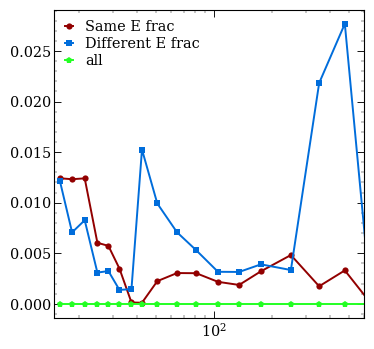

In [85]:
all_corr = read_corrections('_QCD-MG-Her', 'all') - read_corrections('_QCD-MG-Her', 'all')
fig, ax = plt.subplots()
ax.plot(ptbins_c,np.abs(RZjet)[:,0], label='Same E frac')
ax.plot(ptbins_c,np.abs(RZjet2)[:,0], label='Different E frac')
ax.plot(ptbins_c,all_corr[:,0], label='all')
# ax.plot(ptbins_c,np.abs(Rttbar) - np.abs(Rref))[:,0])
# ax.plot(ptbins_c,(np.abs(Rdijet) - np.abs(Rref))[:,0])
ax.legend()
ax.set_xlim(15,600)
ax.set_xscale('log')
1;

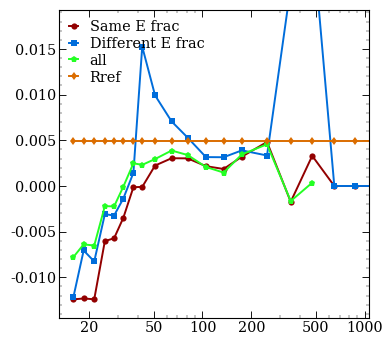

In [109]:
all_corr = read_corrections('_DY-MG-Her', 'all')/read_corrections('_DY-MG-Py', 'all')-1
# all_corr2 = read_corrections('_DY-MG-Her', 'all')-read_corrections('_DY-MG-Py', 'all')
fig, ax = plt.subplots()
ax.plot(ptbins_c,RZjet[:,0], label='Same E frac')
ax.plot(ptbins_c,RZjet2[:,0], label='Different E frac')
ax.plot(ptbins_c,all_corr[:,0], label='all')
# ax.plot(ptbins_c,all_corr2[:,0], label='all2')

ax.plot(ptbins_c,Rref[:,0], label='Rref')
# ax.plot(ptbins_c,np.abs(Rttbar) - np.abs(Rref))[:,0])
# ax.plot(ptbins_c,(np.abs(Rdijet) - np.abs(Rref))[:,0])


ax.set_xscale('log')
ax.set_xticks([])
ax.set_xticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ylims = ax.get_ylim()
ax.set_xlim(xlims)
ax.set_ylim(ylims[0], ylims[1]*0.65)
# ax.set_ylabel('')


ax.legend(loc='upper left')
# ax.set_xlim(15,600)
1;

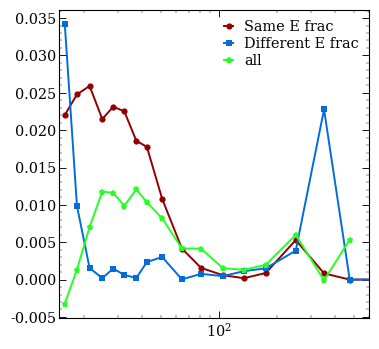

In [64]:
all_corr = read_corrections('_DY-MG-Her', 'all')/read_corrections('_DY-MG-Py', 'all')-1
fig, ax = plt.subplots()
ax.plot(ptbins_c,np.abs(RZjet)[:,0], label='Same E frac')
ax.plot(ptbins_c,np.abs(RZjet2)[:,0], label='Different E frac')
ax.plot(ptbins_c,all_corr[:,0], label='all')
# ax.plot(ptbins_c,np.abs(Rttbar) - np.abs(Rref))[:,0])
# ax.plot(ptbins_c,(np.abs(Rdijet) - np.abs(Rref))[:,0])
ax.legend()
ax.set_xlim(15,600)
ax.set_xscale('log')
1;

(15.0, 600.0)

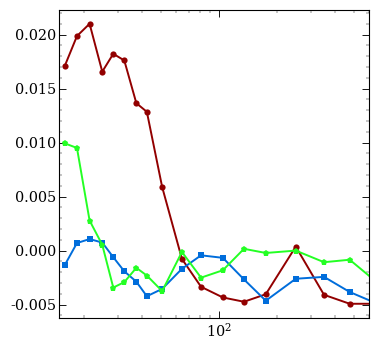

In [39]:
fig, ax = plt.subplots()
ax.plot(ptbins_c,(np.abs(RZjet) - np.abs(Rref))[:,0])
ax.plot(ptbins_c,(np.abs(Rttbar) - np.abs(Rref))[:,0])
ax.plot(ptbins_c,(np.abs(Rdijet) - np.abs(Rref))[:,0])
ax.set_xlim(15,600)
ax.set_xscale('log')

In [365]:
np.abs(Rttbar) - np.abs(Rref)

array([[-1.68233913e-03, -2.24234550e-04,  4.47151874e-03, ...,
        -3.57246773e+06, -3.31171064e+06, -2.56683815e+06],
       [ 3.58346914e-04,  5.37771232e-03, -3.18202443e-04, ...,
        -7.09949592e+05, -2.72728128e+06, -2.64419296e+06],
       [ 7.27310098e-04,  3.20009713e-04,  3.52742975e-04, ...,
        -3.92876624e+06, -3.27420661e+06, -2.43255449e+06],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])

In [371]:
Rttbar[:,0]

array([-3.57997151e-03, -5.62065755e-03, -5.98962073e-03, -5.66635247e-03,
       -4.31030847e-03, -3.00431630e-03, -2.04545368e-03, -6.95981916e-04,
        1.37722212e-03,  3.23464470e-03,  4.48414965e-03,  4.25136110e-03,
        2.25260661e-03, -2.81350733e-04, -2.31508951e-03, -2.48951023e-03,
       -1.09007927e-03,  4.96832476e-05, -2.50230334e-03, -9.47861937e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                   nan,             nan,             nan,             nan])

In [341]:
RZjet[np.searchsorted(ptbins_c, 200), 0]

0.005262310632818834

In [177]:
DRflav = np.abs(Rttbar) - np.abs(Rref)
DRflav

array([[-0.05200345, -0.05339711, -0.05401943, ..., -0.05276563,
        -0.08676747, -0.06674879],
       [-0.05196416, -0.05312682, -0.05227553, ..., -0.0534091 ,
        -0.09642532, -0.07535077],
       [-0.05193788, -0.05184879, -0.05222941, ..., -0.05726413,
        -0.11385565, -0.09338348],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [412]:
R_mix_dict = hist_mult(
    hist_add(
        correction_dict['_Herwig-TTBAR'],
        hist_mult(correction_dict['_Pythia-TTBAR'],-1)
    ),
    qfrac_dict['_Herwig-TTBAR'])

In [413]:
# R_mix_dict

{'g': array([[ 0.00197178,  0.00224616,  0.00223491, ...,  0.0043882 ,
         -0.00058536,  0.00166266],
        [ 0.00261992,  0.00283154,  0.00286385, ...,  0.0049895 ,
          0.00086897,  0.00185507],
        [ 0.00263753,  0.00281219,  0.00273248, ...,  0.00361315,
          0.00098622,  0.00123152],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]),
 'c': array([[-2.18133424e-04, -2.91913065e-04, -2.18621081e-04, ...,
          2.66068655e-04,  1.01836283e-04,  3.27730071e-04],
        [-3.33571398e-04, -3.05603978e-04, -2.93866530e-04, ...,
          1.35843138e-04, -9.28091162e-06,  2.64694382e-04],
        [-5.18987314e-04, -5.42041318e-04, -5.69035835e-04, ...,
         -9.73581362e-06,  3.39890925e-05,  1.

In [355]:
qfracs = {'all': sum_neg_pos_eta(hists['all']).values()}
for flav in hists.keys():
    if 'all' in flav:
        continue
    qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])

/tmp/anpotreb/ipykernel_2302/4094375483.py:5: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])


In [401]:
# flavors = ['g', 'c', 'b', 'q']
# data_read0 = {flav: read_data("Median", flav, "_L5"+samples[0]+"_fineeta",'../') for flav in flavors}
# data_read1 = {flav: read_data("Median", flav, "_L5"+samples[1]+"_fineeta",'../') for flav in flavors}


In [402]:
# etabins = np.array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839, -3.664, -3.489,
#                         -3.314, -3.139, -2.964, -2.853,  -2.65,   -2.5, -2.322, -2.172, -2.043,  -1.93, 
#                         -1.83,  -1.74, -1.653, -1.566, -1.479, -1.392, -1.305, -1.218, -1.131, -1.044,
#                         -0.957, -0.879, -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
#                         -0.087,  0,  0.087,  0.174,  0.261,  0.348,  0.435,  0.522,  0.609,  0.696, 
#                         0.783,  0.879,  0.957,  1.044,  1.131,  1.218,  1.305,  1.392,  1.479,  1.566, 
#                         1.653,   1.74,   1.83,   1.93,  2.043,  2.172,  2.322,    2.5,   2.65,  2.853,
#                         2.964,  3.139,  3.314,  3.489,  3.664,  3.839,  4.013,  4.191,  4.363,  4.538,
#                         4.716,  4.889, 5.191])
# jeteta_axis = hist.axis.Variable(etabins, name="jeteta", label=r"Jet $\eta$")

# # jeteta_axis = hist.axis.(etabins, name="jeteta", label=r"Jet $\eta$")


In [358]:
# hist_Pl = rebin_hist(bla2, 'jeteta', edPl)
# hist_Mi = rebin_hist(bla2, 'jeteta', edMi)

# hist_MiPl = mirror_eta_to_plus(hist_Mi)
# hist_MiPl+hist_Pl

In [403]:
# qfracs2 = {key: qfracs[key] for key in qfracs.keys() if key in flavors}

In [404]:
# sum(qfracs2.values())

In [368]:
R_Zjet = sum(R_mix.values())

<IPython.core.display.Javascript object>


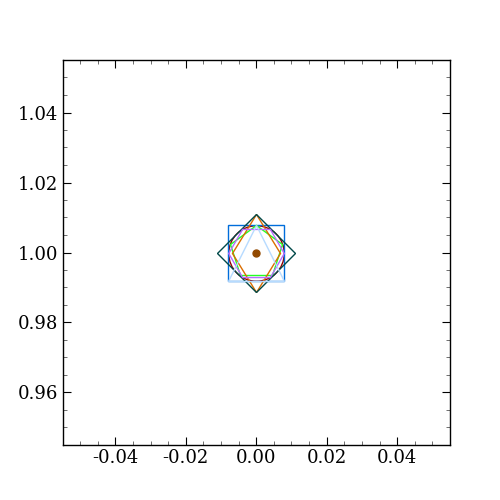

In [38]:
fig, ax = plt.subplots()
for i in range(7):
    ax.plot([1], markersize=40, mfc='none', mew=1)
ax.plot([1],  '.', markersize=10, mew=1)
# ax.set_xlim([-0.02,0.02])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from cycler import cycler

In [96]:
# plt.style.use('default')
pltStyle('presentation-square')
# hep.style.use("ATLAS")
my_parms = plt.rcParams.copy()
plt.style.use(hep.style.ROOT)
root_parms = plt.rcParams.copy()
# cols_cyc = cycler(color=colourblind_cols)

In [ ]:
parms_default = plt.rcParams.copy()

In [144]:
qfracs2 = {key: qfracs[key] for key in qfracs.keys() if key in flavors}

In [135]:
qfracs['q'].shape

(28, 82)

In [154]:
li = np.array([1,2,3,5,6])

In [156]:
li[[1,4]]

array([2, 6])

In [124]:
for key in root_parms.keys():
    if "legend" in key:
        print(key, root_parms[key])

legend.borderaxespad 0.5
legend.borderpad 0.5
legend.columnspacing 2.0
legend.edgecolor 0.8
legend.facecolor inherit
legend.fancybox True
legend.fontsize small
legend.framealpha 0.8
legend.frameon False
legend.handleheight 0.7
legend.handlelength 1.5
legend.handletextpad 0.8
legend.labelspacing 0.5
legend.loc best
legend.markerscale 1.0
legend.numpoints 1
legend.scatterpoints 1
legend.shadow False
legend.title_fontsize None


In [97]:
for key in my_parms.keys():
    if my_parms[key] == root_parms[key]:
        continue
    
    print(key, ", my_parms = ", my_parms[key], ", ROOT style = ", root_parms[key])

axes.labelsize , my_parms =  8.8 , ROOT style =  medium
axes.linewidth , my_parms =  0.8 , ROOT style =  2.0
axes.unicode_minus , my_parms =  True , ROOT style =  False
figure.figsize , my_parms =  [3.7, 3.5] , ROOT style =  [10.0, 10.0]
font.sans-serif , my_parms =  ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif'] , ROOT style =  ['TeX Gyre Heros', 'Helvetica', 'Arial']
font.size , my_parms =  10.0 , ROOT style =  26.0
grid.alpha , my_parms =  1.0 , ROOT style =  0.8
grid.linestyle , my_parms =  - , ROOT style =  :
legend.borderpad , my_parms =  0.4 , ROOT style =  0.5
legend.fontsize , my_parms =  8.0 , ROOT style =  small
legend.frameon , my_parms =  True , ROOT style =  False
legend.handlelength , my_parms =  2.0 , ROOT style =  1.5
mathtext.bf , my_parms =  sans:bold , ROOT style =  TeX Gyre Heros:bold
mathtext.cal , my_parms =  cursive , ROOT style =  TeX Gyre Her

In [ ]:
for key in plt.rcParams.keys():
    if "line" not in key:
        continue
    print(key, plt.rcParams[key])

In [ ]:
for key in plt.rcParams.keys():
    if "line" not in key:
        continue
    print(key, plt.rcParams[key])

In [158]:
import hist
hist.rebin(2)

rebin(2)

In [ ]:
plt.rcParams

In [ ]:
plt.plot([1,4,3,6,8,9], color='b', marker='.', linewidth=0, markersize=24, markerfacecolor='white', markeredgewidth=1)

In [306]:
ed = bla2.axes.edges[1]
edPl = ed[ed>=0]
edMi = ed[ed<=0]
jeteta_axis_Pl = hist.axis.Variable(edPl, name="jeteta", label=r"Jet $\eta$")
jeteta_axis_Mi = hist.axis.Variable(edMi, name="jeteta", label=r"Jet $\eta$")

In [ ]:
allhistval = all_hist.values()
plot_range = range(0, len(ptbins_c)-9) if 'DY' in add_tag else range(0, len(ptbins_c)-6)
ptbins_c_plot = ptbins_c[plot_range]
q_frac = (hists['q'].values()/allhistval)[plot_range]
g_frac = (hists['g'].values()/allhistval)[plot_range]
b_frac = (hists['b'].values()/allhistval)[plot_range]
c_frac = (hists['c'].values()/allhistval)[plot_range]
# unt_frac = (untagged_hist.values()/allhistval)[plot_range]

fig, ax = plt.subplots()
ax.plot(ptbins_c_plot, q_frac, 'o', label="uds")
ax.plot(ptbins_c_plot, c_frac, 'o', label="c")
ax.plot(ptbins_c_plot, b_frac, 'o', label="b")
ax.plot(ptbins_c_plot, g_frac, 'o', label="g")
# ax.plot(ptbins_c_plot, unt_frac, 'o', label="untagged")
ax.set_xscale('log')
ax.set_xlabel('$p_{T,Gen}$ (GeV)')
ax.set_ylabel("Flavor fraction")
# fig.suptitle("Blaaah $x^2_5$")

xlims = ax.get_xlim()

ax.set_xticks([])
ax.set_xticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
leg1 = ax.legend(ncol=2)

ax.set_xlim(xlims)

import os
if not os.path.exists("../fig/fractions"):
    os.mkdir("../fig/fractions")
    
fig_name = '../fig/fractions/fraction'+tag_full
print("Saving plot with the name = ", fig_name)
plt.savefig(fig_name+'.pdf');
plt.savefig(fig_name+'.png');

# ptbins_c
1;

In [301]:
# # h = hist_Mi
# def mirror_eta_to_plus(h):
#     ''' Mirror negative eta bins in histogram to positive eta bins
#     '''
#     axis_name = 'jeteta'
#     ax = h.axes[axis_name]
#     ax_idx = [a.name for a in h.axes].index(axis_name)
    
#     overflow = ax.traits.overflow or (edges[-1] < ax.edges[-1] and not np.isclose(edges[-1], ax.edges[-1]))
#     underflow = ax.traits.underflow or (edges[0] > ax.edges[0] and not np.isclose(edges[0], ax.edges[0]))
#     flow = overflow or underflow
#     new_eta_edges = h.axes[0].edges[::-1]*(-1)
# #     if (new_eta_edges>0).any() and (new_eta_edges<0).any():
# #         Maybe a bug?
#     new_ax = hist.axis.Variable(h.axes[0].edges[::-1]*(-1), name=ax.name, overflow=overflow, underflow=underflow)
#     axes = list(h.axes)
#     axes[ax_idx] = new_ax

#     hnew = hist.Hist(*axes, name=h.name, storage=h._storage_type())

#     hnew.values(flow=flow)[...]=h.values(flow=flow)[::-1]
#     if hnew._storage_type() == hist.storage.Weight():
#         hnew.variances(flow=flow)[...] = h.variances(flow=flow)[::-1]
#     return hnew